# Don -  Classification Using CNN from PyTorch
## Goal:
Build a deep learning model to classify images using a CNN model with PyTorch and experiment with ways on improving accuracy.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tarfile

# 1. (Optional) Extract binary data from the ".tar.gz" file

If the user has not extracted the binary files from before, than the code below can be used to do so.

In [11]:
current_folder = '/Users/doncheung/Desktop/AMSI/Assignment 2' # modify this according to your local file location

extract_this = f'{current_folder}/stl10_binary.tar.gz'
tar = tarfile.open(extract_this, "r:gz")
tar.extractall()
tar.close()

/var/folders/8x/cmwt_bmn6c94q9zn4jqg68k40000gn/T/ipykernel_1300/3607431567.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


# 2. Loading the binary files

Instead of using ".png" files, we directly use the binary files as our data with the PyTorch CNN module.

In [14]:
def load_split(split): # train, test
    X_path = f'stl10_binary/{split}_X.bin'
    y_path = f'stl10_binary/{split}_y.bin'
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major
    y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
    y = y - 1 #convert range [1,10] to [0,9]
    print('-----------------')
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y

full_train_X, full_train_y = load_split('train')
full_test_X, full_test_y = load_split('test')

-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)


# 3. View class names and images as a sanity check

In [15]:
with open('stl10_binary/class_names.txt') as f:
    full_class_names = f.readlines()

full_class_names = [name.strip() for name in full_class_names]

print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


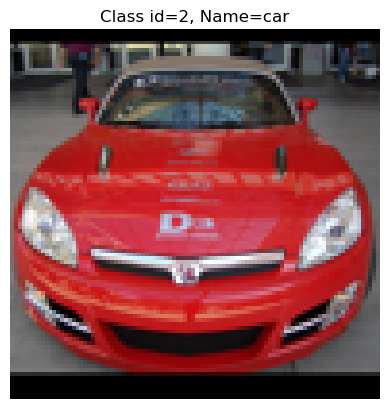

In [16]:
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

i = np.random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

# 4. Split for 2 class classifcation

In [17]:
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

def subsplit_two_classes(X, y, split):
    indices = np.where(np.logical_or(y==ID_C1_OLD, y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(np.uint8) * ID_C1_NEW + (y_out == ID_C2_OLD).astype(np.uint8) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


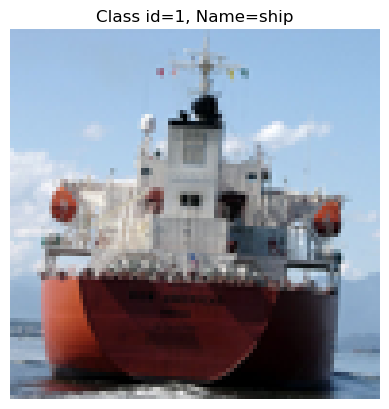

In [11]:
# Visualising sample from the training set
i = np.random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

# 5. Load the data for the 2 classes

In [18]:
class ArrayDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]

BATCH_SIZE = 16

loader_two_classes_train = DataLoader(dataset = ArrayDataset(train_two_classes_X, train_two_classes_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_two_classes_test = DataLoader(dataset = ArrayDataset(test_two_classes_X, test_two_classes_y),
                                     batch_size=1,
                                     shuffle=True)

# 6. Design the CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_out_classes): # do we need to use num_out_classes?
    
        super(CNN, self).__init__()
        
        num_filters = [3, 6, 12, 24, 64]
    
        # expected size of input to following layer: 3x96x96
        self.conv1 = nn.Conv2d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters[1])
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(in_channels=num_filters[1],
                               out_channels=num_filters[2],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=num_filters[2])
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv3 = nn.Conv2d(in_channels=num_filters[2],
                               out_channels=num_filters[3],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=num_filters[3])
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3456, 18)
        self.fc2 = nn.Linear(18,32)
    
    def forward(self, x):
        # bring input to [-1,1] range
        x = x.float() / 128.0 - 1.0
        # sequence of operations: convolution --> batch normalization --> non-linearity --> pooling
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))  
        x = x.view(-1, 24*12*12) # before passing to fully connected layer
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x) 
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x    

# 7. Compute accuracy before training the CNN

In [19]:
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output = True):
  
    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0

    for i, batch in enumerate(data_loader):
        # get the inputs and labels
        X_batch, y_batch = batch
        # calculate predictions given a batch of samples      
        predictions_batch = cnn(X_batch)
        # convert each prediction into a class id
        _, vals = torch.max(predictions_batch, 1)
        # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum()
        total_samples += y_batch.shape[0]
        out_accuracy = int(total_accuracy) * 1.0 / total_samples

    if print_output:
        print(f'Accuracy over "{split}" split is {100 * out_accuracy:02f}%')

    return 100 * out_accuracy

In [33]:
cnn_two_classes = CNN(num_out_classes = 2)
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size(

0.0

# 8. Now train the CNN

In [28]:
def train(cnn,
          loader_train,
          loader_test,
          num_epochs,
          learning_rate = 0.001,
          track_accuracy = False):
  
    # define the loss to be minimized
    # https://pytorch.org/docs/stable/nn.html#crossentropyloss
    criterion = nn.CrossEntropyLoss() #loss function

    # create an optimizer 
    # You can read more about optimizers here: https://pytorch.org/docs/stable/optim.html
    # You may try with different optimizers and check if that makes any difference
    # For any one optimizer, try changing the learning rate and observe the effect.
    optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
    
    # set the model into training mode
    cnn.train() 

    tr_acc = []
    ts_acc = []

    tr_loss = []
    ts_loss = []

    # In each epoch, run the optimizer operation on each batch
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, batch in enumerate(loader_train):
            X_batch, y_batch = batch
            y_batch = y_batch.type(torch.long)
            optimizer.zero_grad() # zero the parameter gradients
            predictions_batch = cnn(X_batch)             # forward pass
            loss = criterion(predictions_batch, y_batch)             # calculate loss for the provided predictions and ground truth labels
            epoch_loss += float(loss)
            loss.backward()
            optimizer.step()
       
       ### Extra code for test loss (epoch loss is for training loss)
        float_test_loss = 0.0
        for i, batch in enumerate(loader_test):
            X_batch, y_batch = batch
            y_batch = y_batch.type(torch.long)
            optimizer.zero_grad() # zero the parameter gradients
            predictions_batch = cnn(X_batch)
            test_loss = criterion(predictions_batch, y_batch)
            float_test_loss += float(test_loss)
            test_loss.backward()
            optimizer.step()
       
            
        if track_accuracy:
            tr_acc.append(compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False))
            ts_acc.append(compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False))
            
            tr_loss.append(epoch_loss)
            ts_loss.append(float_test_loss)

        epoch_loss /= len(loader_train)
        print('Epoch {}/{} training loss {:02f}'.format(epoch+1, num_epochs, epoch_loss))

    if track_accuracy:
        # plt.figure()
        # plt.plot(np.array(tr_acc))
        # plt.plot(np.array(ts_acc))
        # plt.legend(['training accuracy', 'test accuracy'])
        # plt.xlabel('training iterations')
        # plt.show()
        # plt.close()

        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1)
        plt.plot(np.array(tr_acc))
        plt.plot(np.array(ts_acc))
        plt.legend(['training accuracy', 'test accuracy'])
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.subplot(1,2,2)
        plt.plot(np.array(tr_loss))
        plt.plot(np.array(ts_loss))
        plt.legend(['training loss', 'test loss'])
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.show()
        plt.close()

    print('Finished Training')

torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size(

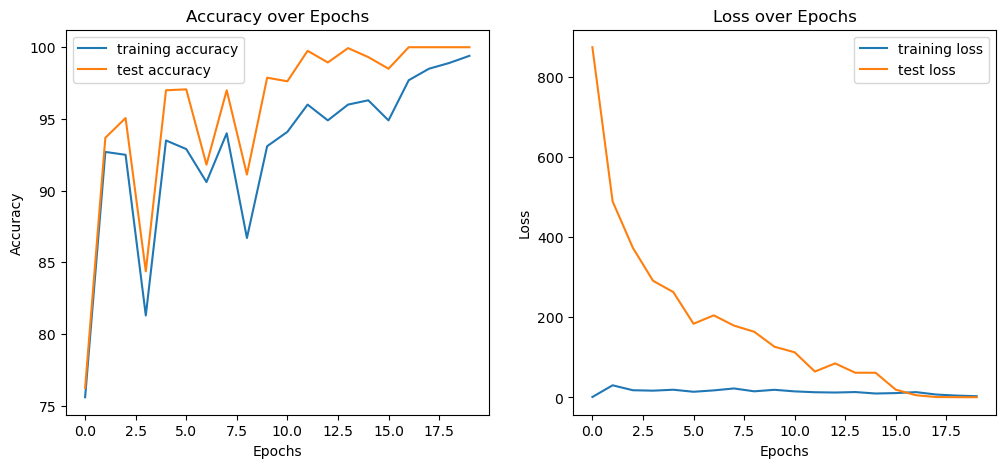

Finished Training


In [57]:
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 20,
      track_accuracy = True)

# 9. Compute accuracy after traning the CNN

In [90]:
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size([16, 3456])
torch.Size(

100.0

# 10. Now repeat the process for 10 classes (instead of 2)

In [22]:
loader_ten_classes_train = DataLoader(dataset = ArrayDataset(full_train_X, full_train_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_ten_classes_test = DataLoader(dataset = ArrayDataset(full_test_X, full_test_y),
                                     batch_size=1,
                                     shuffle=True)

Computing accuracy before training the model

In [99]:
cnn_ten_classes = CNN(num_out_classes = 10)

compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

RuntimeError: running_mean should contain 96 elements not 64

Training the 10 class CNN model

torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size(

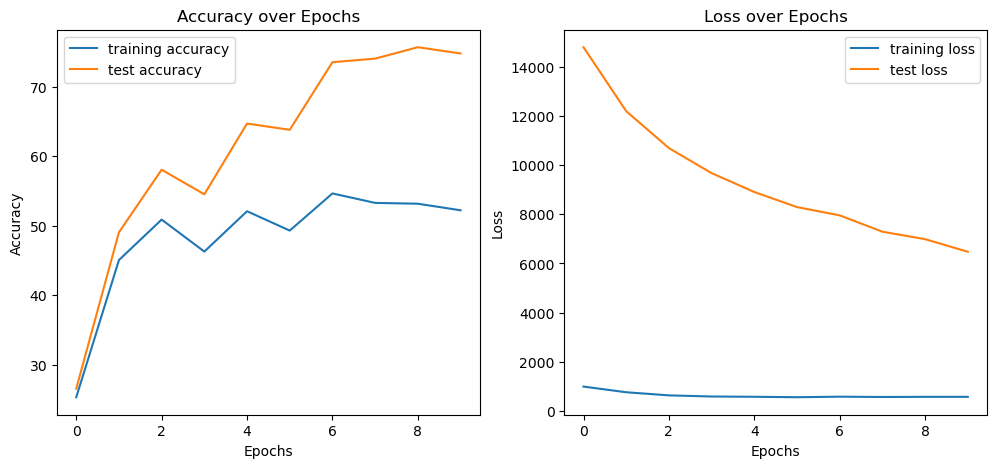

Finished Training


In [61]:
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 10,
      track_accuracy = True)

After training, computing accuracy for 10 class CNN model

In [117]:
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size([10, 3456])
torch.Size(

50.5625

# Johan's version all in one

In [ ]:
import torchvision.transforms as transforms
import torchvision
import torch

train_transform=transforms.Compose([
        transforms.RandomCrop((64, 64)),
        #transforms.TrivialAugmentWide(),
        transforms.RandomEqualize(),
        #transforms.GaussianBlur(kernel_size=(5,9)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
test_transform=transforms.Compose([
        transforms.CenterCrop(size=(64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])


default_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

current_folder = '/Users/doncheung/Desktop/AMSI/Assignment 2'
path = current_folder
BATCH_SIZE = 16

trainset = torchvision.datasets.STL10(root=path,
                          split="train", 
                          transform=train_transform, 
                          download=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.STL10(root=path,
                         split="test",
                         transform=test_transform,
                         download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

In [30]:
class ConvNet(nn.Module):
    def __init__(self, num_out_classes):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3)
        self.conv3=nn.Conv2d(32,64,3)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64*6*6, 64)
        self.fc2 = nn.Linear(64,10)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        # x = x.float() / 128.0 - 1.0
        # Input = 3x64x64
        x = nn.functional.gelu(self.conv1(x))
        x = self.pool(self.bn1(x))
        # dimensions = 8x62x62 after conv1, reduced to 8x31x31 after pool
        x = nn.functional.gelu(self.conv2(x))
        x = self.pool(self.bn2(x))
        # dimensions = 32x29x29 after conv2, reduced to 32x14x14 after pool (floor(32x14.5x14.5))
        x = nn.functional.gelu(self.conv3(x))
        x = self.pool(self.bn3(x))
        # dimensions = 64x12x12 after conv3, reduced to 64x6x6 after pool
        #print(x.shape)
        x = x.view(-1, 64*6*6)
        # x has now been vectorised
        x = nn.functional.sigmoid(self.fc1(x))
        # tensor now has been reshaped to dimension 32x8
        x = nn.functional.dropout(x, p=0.4)
        #print(x.shape)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

Epoch 1/10 training loss 2.216856
Epoch 2/10 training loss 1.835242
Epoch 3/10 training loss 1.694374
Epoch 4/10 training loss 1.635701
Epoch 5/10 training loss 1.584680
Epoch 6/10 training loss 1.518738
Epoch 7/10 training loss 1.517118
Epoch 8/10 training loss 1.485454
Epoch 9/10 training loss 1.473322
Epoch 10/10 training loss 1.476201


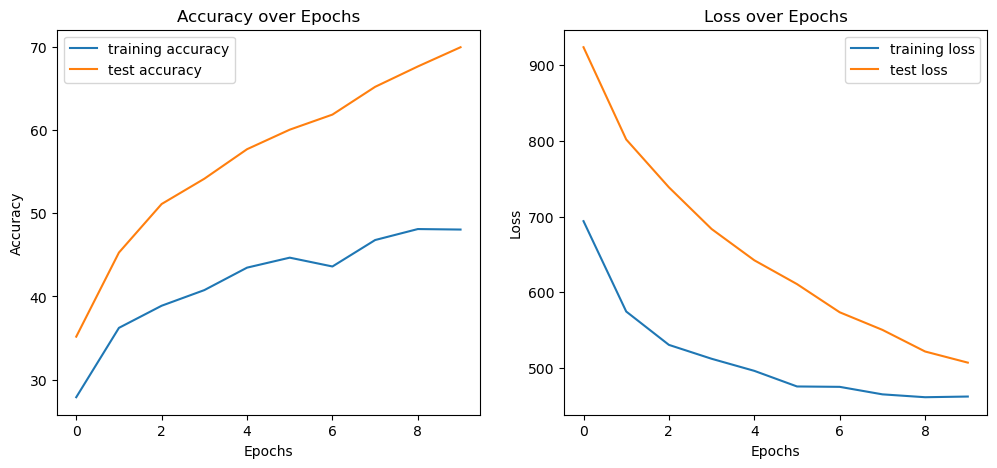

Finished Training
Accuracy over "train" split is 49.120000%
Accuracy over "test" split is 70.112500%


70.1125

In [31]:
cnn_ten_classes = ConvNet(num_out_classes = 10)

train(cnn = cnn_ten_classes,
      loader_train = trainloader,
      loader_test = testloader,
      num_epochs = 10,
      track_accuracy = True)

compute_accuracy(data_loader = trainloader,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = testloader,
                 cnn = cnn_ten_classes,
                 split = 'test')